In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from yellowbrick.model_selection import FeatureImportances


RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

C:\Users\matfs\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Introduction:

DataSet: https://www.kaggle.com/uciml/pima-indians-diabetes-database

The goal of this project is to develop a Machine Learning model capable of predicting if a woman has diabetes, with some parameters, such as glucose in the last blood exam or insulin. This model will be a classifier and it will be tested through some different alternatives to check which one has the best outcome. 

Dependent variable: Outcome

Examples of Independent Variables: Life expectancy and Poverty rates

In [2]:
diabetes = pd.read_csv('diabetes.csv')

diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


# First look at the database

In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We can learn through the info function that there are no null values in the database, therefore we don't need to address any solution to the missing values

In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


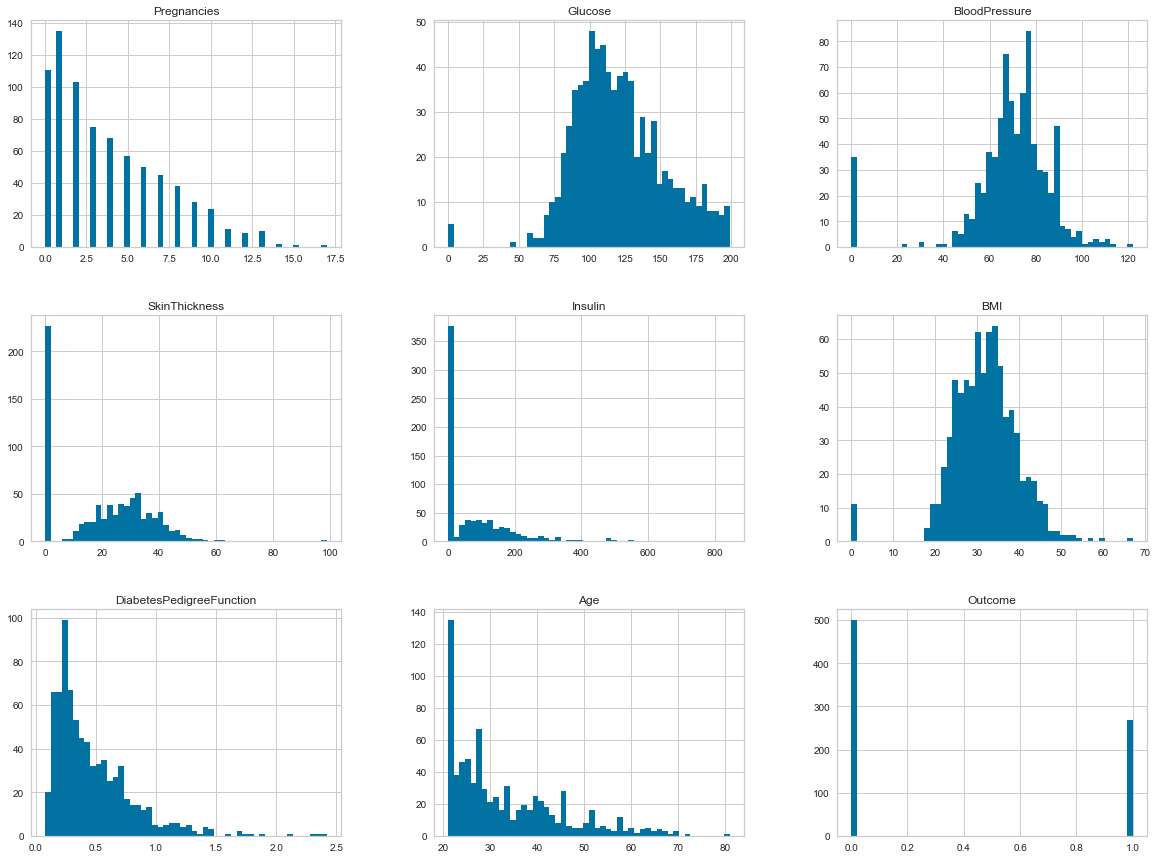

In [5]:
diabetes.hist(bins=50, figsize=(20, 15))
plt.show()

### Missing Values

As we can see, the dabatabase don't have null values, but, there are multiple 0s. This would make sense in some cases, such as pregnancies, but in others, for example, inslulin and blood pressure. This situations needs to be addressed. The approach we'll take will be by replacing the mean values of the whole column to the missing value. 

# Dividing in Train Test

We will be making the division of the train and test set stratifically. This is due to the fact that the parameter "Diabetes Pedigree Function" is believed to have a huge impact on the outcome, therefore, we believe that the train and the test sets should have the same proportion. Also, as we have a small amount of samples (m = 768) this type of separation can be useful  since, if we were to not to use it, the proportion would be unequal.

In [6]:
q = diabetes['DiabetesPedigreeFunction'].quantile([0.2,0.4,0.6,0.8]).values

def check_pedigree(x):
    result = 0
    for val in q:
        if x > val:
            result += 1
        else:
            break
    return result
diabetes['pedigree_cat'] = diabetes['DiabetesPedigreeFunction'].apply(check_pedigree)
diabetes['pedigree_cat'].value_counts(True)

0    0.200521
2    0.200521
3    0.200521
1    0.199219
4    0.199219
Name: pedigree_cat, dtype: float64

In [7]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
for train_index, test_index in split.split(diabetes, diabetes['pedigree_cat']):
    strat_train_set = diabetes.loc[train_index]
    strat_test_set = diabetes.loc[test_index]

In [8]:
print(strat_train_set['pedigree_cat'].value_counts(True), '\n', strat_test_set['pedigree_cat'].value_counts(True))

0    0.200326
2    0.200326
3    0.200326
4    0.200326
1    0.198697
Name: pedigree_cat, dtype: float64 
 0    0.201299
1    0.201299
2    0.201299
3    0.201299
4    0.194805
Name: pedigree_cat, dtype: float64


As we can see, both test and train has the same proportions of values.

In [9]:
#Now we need to drop the created column
strat_train_set.drop(['pedigree_cat'], axis=1, inplace=True)
strat_test_set.drop(['pedigree_cat'], axis=1, inplace=True)

# Exploratory analysis

In [10]:
diabetes_train = strat_train_set.copy()

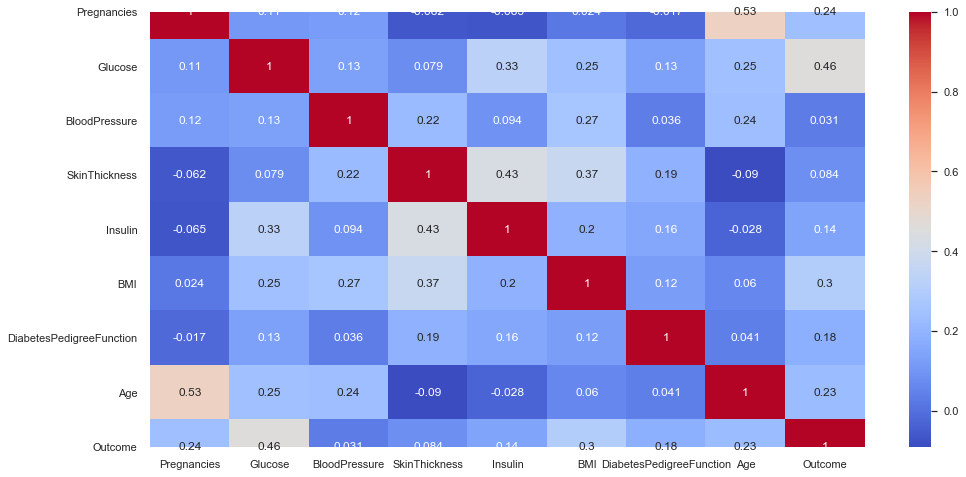

In [11]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr()
sns.heatmap(corr,annot=True,cmap="coolwarm")

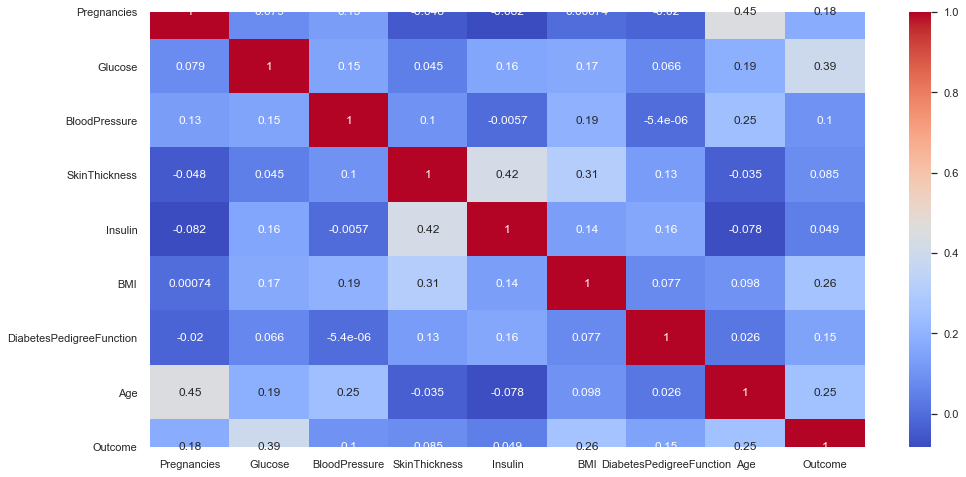

In [12]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr(method='kendall')
sns.heatmap(corr,annot=True,cmap="coolwarm")

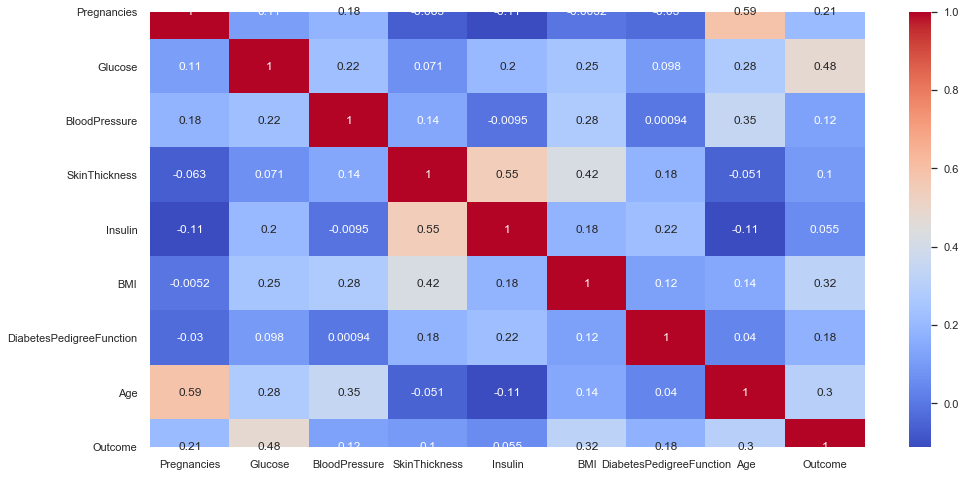

In [13]:
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
corr = diabetes_train.corr(method='spearman')
sns.heatmap(corr,annot=True,cmap="coolwarm")

As we can see, the kendall correlation seems to be the one with the higher values for the outcome relation with other variables. This indicates that the relationship between the outcome and other variables may not be linear.

We can see that the correlation between age and pregnancies is the highest. Also, the outcome appears to have some kind of relation with glucose.

# Separating Independent and Dependent Variables

In [14]:
#Replacing the 0s with Nan so that SimpleImputer can operate
strat_train_set = strat_train_set.replace(to_replace={
             'BloodPressure':{0:np.nan}, 
             'Insulin':{0:np.nan},
             'SkinThickness':{0:np.nan},
             'BMI':{0:np.nan},
             'Glucose':{0:np.nan},
                 })
strat_train_set.dropna(subset=['BMI', 'BloodPressure', 'Glucose'], inplace = True)

diabetes_train = strat_train_set.drop('Outcome', axis=1)

diabetes_labels = strat_train_set['Outcome'].copy()

## Replacing Invalid values

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


diabetes_in = diabetes_train.copy()

imputer = IterativeImputer(max_iter=10, random_state=0)

imputer.fit(diabetes_in)

IterativeImputer(random_state=0)

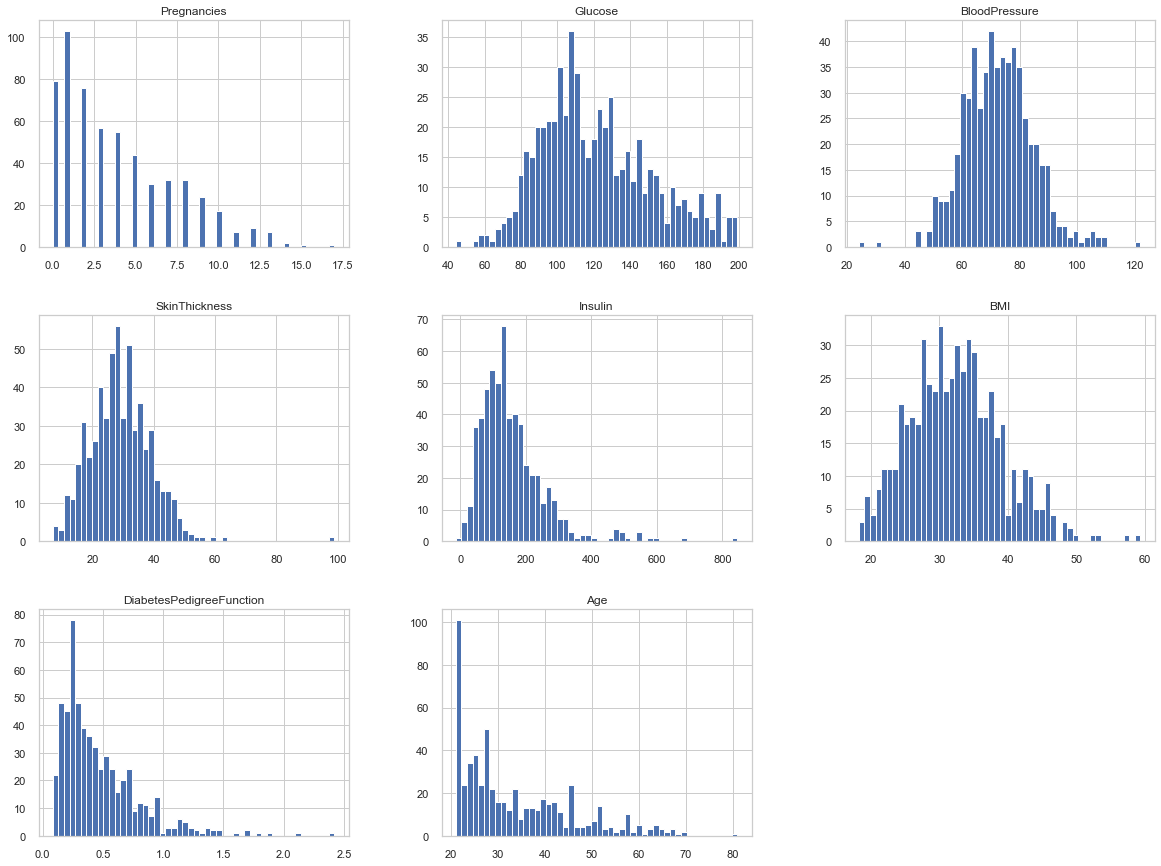

In [16]:
temp = imputer.transform(diabetes_in)

diabetes_inputed = pd.DataFrame(temp, columns=diabetes_in.columns)

diabetes_inputed.hist(bins=50, figsize=(20, 15))
plt.show()

After applying a inputer that used a logistic regression to resolve with the values with 0, the data looks much better.

In [17]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(diabetes_inputed)

temp = scaler.transform(diabetes_inputed)

diabetes_train = pd.DataFrame(temp, columns=diabetes_inputed.columns)
diabetes_train

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,0.614986,1.460390,0.119633,-0.171435,1.079669,-0.863342,-0.513290,2.715500
1,2.374415,-0.691978,0.943900,0.399656,-0.504260,-0.358499,0.054719,1.040666
2,1.201462,-0.431085,-0.210074,-0.217194,-0.348935,-0.284258,1.496351,-0.047977
3,-0.851206,-0.822425,4.076116,-1.232505,-0.975099,-1.486971,-0.812730,-0.550427
4,-0.851206,-1.115929,-1.034341,0.807934,-0.802723,0.710580,0.119546,-0.969136
...,...,...,...,...,...,...,...,...
571,2.081177,1.101662,0.284487,-0.110691,-0.056565,0.131495,2.724980,1.459374
572,0.614986,-1.181153,0.449340,-0.121571,-0.775738,-0.180319,-0.272503,0.705699
573,-1.144444,-0.626755,-0.704634,1.726559,-0.772877,1.215422,0.079415,-1.052878
574,1.787939,0.384206,-0.374927,-0.488084,0.137989,-0.803949,-0.695423,0.203248


# Binary Classifier

In [18]:
from sklearn.linear_model import SGDClassifier

# Existe aleatoriedade dentro do SGDClassifier, por isso o argumento
# random_state=RANDOM_SEED.
sgd_clf = SGDClassifier(
    max_iter=500,
    tol=1e-3,
    random_state=RANDOM_SEED,
)
sgd_clf.fit(diabetes_train, diabetes_labels)

SGDClassifier(max_iter=500, random_state=42)

### Cross Validation

Before we test the performance of the Model "SGD Classifier" we should know the proportions of the target variable. The reason for this is because if the data has a proportion of 80% of people who have diabetes and 20% who haven´t, and the Classifier has an accuracy of 80%, the model would be as bad as one who just guess constanly "user with diabetes".

In [19]:
diabetes_labels.value_counts(True)

0    0.668403
1    0.331597
Name: Outcome, dtype: float64

In [20]:
import time
from sklearn.model_selection import cross_val_score

t1 = time.process_time()
Binary_score = cross_val_score(
               sgd_clf,
               diabetes_train,
               diabetes_labels,
               cv=10,
               scoring="accuracy",
               n_jobs=-1,
               )
t2 = time.process_time()

print(Binary_score)

[0.63793103 0.77586207 0.79310345 0.77586207 0.74137931 0.70689655
 0.59649123 0.77192982 0.78947368 0.77192982]


Here we see that the model had an accuracy around 73%, which may seem ok (but not good enough). But, when it compares the porportion of people who has diabetes in the data, we realize that this model was almost as bad as one who keeps only guessing "people who don't have diabetes". Therefore, we need to improve.

## Hyperparameters adjusting

It is possible to further improve the performance of the SGDC Classifier by using GridSearch, which combines thousands of possible parameters of the model and finds the best of them. For that, it is necessary to pass a grid of parameters, it is necessary to know the SGDC classifier parameters.

In [21]:
sgd_clf.get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'early_stopping', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter_no_change', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [22]:
# train across 5 folds, that's a total of (6+4)*5=50 rounds of training.
param_grid = {
    'alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3], # learning rate
    'loss': ['log'], # logistic regression,
    'penalty': ['l2'],
    'n_jobs': [-1]
}

sgd_clf_grid = GridSearchCV(
    sgd_clf,  # Modelo
    param_grid,  # Grid
    cv=5,  # Partições de C.V.
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
)

Now, the best SGDC classifier was obtained (that is, the model with the best parameters). With that said, it is necessary to train the model again.

In [23]:
sgd_clf_grid.fit(diabetes_train, diabetes_labels)

GridSearchCV(cv=5, estimator=SGDClassifier(max_iter=500, random_state=42),
             n_jobs=-1,
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0,
                                   1000.0],
                         'loss': ['log'], 'n_jobs': [-1], 'penalty': ['l2']},
             return_train_score=True, scoring='neg_mean_squared_error')

In [24]:
sgd_clf_grid.best_params_

{'alpha': 0.1, 'loss': 'log', 'n_jobs': -1, 'penalty': 'l2'}

After using Grid Search, it is possible to calculate once again the model accuracy, and a higher performance can be observed.

In [25]:
t1 = time.process_time()
Binary_score_grid = cross_val_score(
    sgd_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(Binary_score_grid)

[0.74137931 0.81034483 0.77586207 0.77586207 0.77586207 0.86206897
 0.77192982 0.75438596 0.75438596 0.77192982]


## Feature importance

Lastly, it is also interesting to analyze the features that impacted the most on the prediction of the model. For that, the graphic below was plotted and Insulin was the feature that had the most importance, followed by Glucose and Blood Pressure, the latter having a negative coefficient value, however the magnitude is what matters, and the negative coefficient only indicates that the dependent variable and independent variable have a strong negative correlation. That makes sense, since people with lower Blood Pressure tend to not have diabetes, it is something more predictable. However, when this value gets higher, more outliers can appear, and it becomes more difficult to predict whether a person will have diabetes or not. 

C:\Users\matfs\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


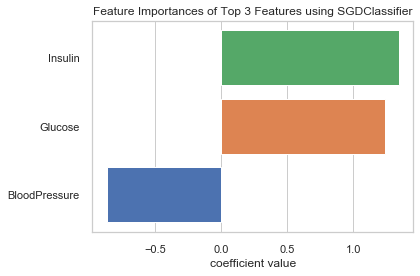

In [26]:
viz = FeatureImportances(sgd_clf, relative=False, topn=3)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

Also, by plotting the importance of the all features, the difference of importance between the three features discussed previously and the reamining features is quite notable.

C:\Users\matfs\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


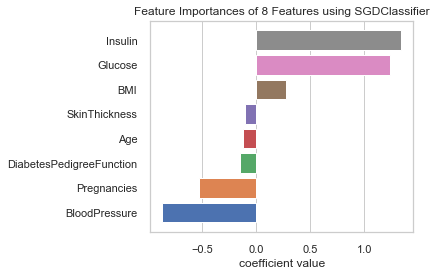

In [27]:
viz = FeatureImportances(sgd_clf, relative=False)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

### Confusion Matrix

Although the accuracy wasn´t really good, it is important to understand in which cases the model has missed. With the confusion matrix it was learned that there was a lot of false negatives. This is unacceptable in this scneario, since the model should never overlook people with diabetes because it is a health situation and people can be harmed if they are not properly diagnosed. Therefore, the model should focous on having a high Recall.

In [28]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf_grid, diabetes_train, diabetes_labels, cv=3, n_jobs=-1)

In [29]:
from sklearn.metrics import confusion_matrix

mat = confusion_matrix(diabetes_labels, y_train_pred)
mat

array([[349,  36],
       [ 87, 104]], dtype=int64)

### Precision Recall

In [30]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(diabetes_labels, y_train_pred))
print(recall_score(diabetes_labels, y_train_pred))

0.7428571428571429
0.5445026178010471


As we can see, the Recall is actually low, and now it is important to adjust this value to make it more accpetable.

In [31]:
y_scores = cross_val_predict(
    sgd_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=3,
    method="decision_function",
    n_jobs=-1,
)

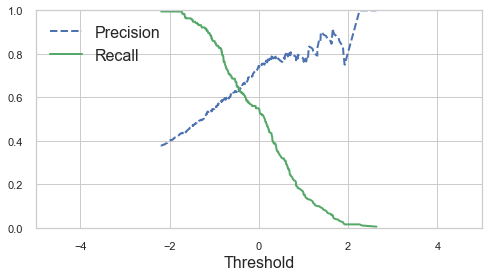

In [32]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(diabetes_labels, y_scores)

plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)

plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="upper left", fontsize=16)
plt.xlim([-5, 5])
plt.ylim([0, 1])
plt.show()

With this graph it is possible to discover a value of Threshold that increases the Recall, which is -0.75. With this, it is possible to adjust the results for the aim of decreasing false negatives

In [33]:
y_train_pred_90 = (y_scores > -0.75)

In [34]:
print('Precision: {}'.format(precision_score(diabetes_labels, y_train_pred_90)))
print('Recall: {}'.format(recall_score(diabetes_labels, y_train_pred_90)))

Precision: 0.5892116182572614
Recall: 0.743455497382199


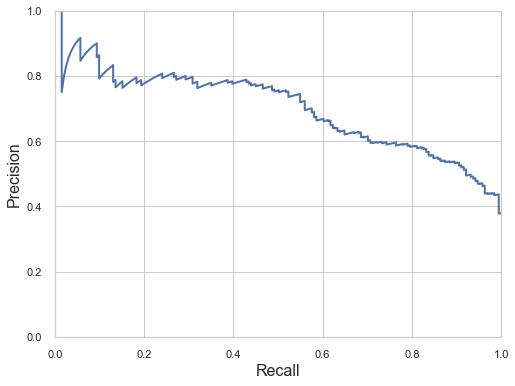

In [35]:
plt.figure(figsize=(8, 6))

plt.plot(recalls, precisions, "b-", linewidth=2)

plt.xlabel("Recall", fontsize=16)
plt.ylabel("Precision", fontsize=16)
plt.axis([0, 1, 0, 1])

plt.show()

It is possible to see that when the Recall is increased, the Precision has the opposite reaction. In the current scneario, this is not a problem, because the goal is to just increase the Recall.

#### ROC Curve

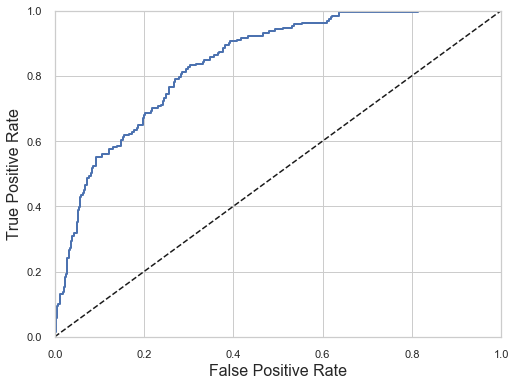

In [36]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(diabetes_labels, y_scores)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.show()

For the diabetes problem, the ideal format of this curve is when the area below the curve is high thus making the curve closer to the upper left corner. With the SGD classifier, the curve obtained does not match the ideal shape. This concept is known as ROC curve and what is desired in the present study is a high sensitivity, or true positive rate, meaning a high recall.

# Random Forest Classifier

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)


t1 = time.process_time()
Rand_Forrest_Score = cross_val_score(
    forest_clf,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(Rand_Forrest_Score)

[0.79310345 0.79310345 0.77586207 0.81034483 0.81034483 0.86206897
 0.73684211 0.70175439 0.71929825 0.75438596]


Through the cross val score, it seems that this classifier has a better perfomance than the SDG.

## Adjusting Hyperparameters 

Similarly to the SGDC model, here the hyperparameters of the model will be adjusted.

In [38]:
forest_clf.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [39]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
}

forest_clf_grid = GridSearchCV(
    forest_clf,  # Modelo
    param_grid,  # Grid
    cv=5,  # Partições de C.V.
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
)

In [40]:
forest_clf_grid.fit(diabetes_train, diabetes_labels)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [80, 90, 100, 110],
                         'max_features': [2, 3], 'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [41]:
forest_clf_grid.best_params_

{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 4,
 'min_samples_split': 8}

Now, with the hyperparameters adjusted, there is a slight improvement to the model's performance.

In [42]:
t1 = time.process_time()
Random_Forrest_grid_Score = cross_val_score(
    forest_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(Random_Forrest_grid_Score)

[0.79310345 0.77586207 0.77586207 0.79310345 0.79310345 0.86206897
 0.75438596 0.68421053 0.75438596 0.75438596]


## Feature Importances

By plotting the features importance graphs, there are some noticable differences:

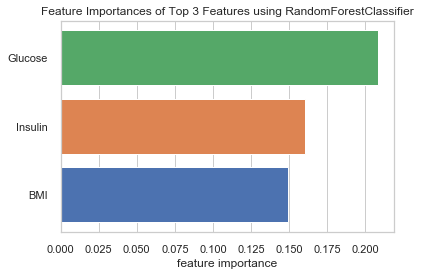

In [43]:
viz = FeatureImportances(forest_clf, relative=False, topn=3)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

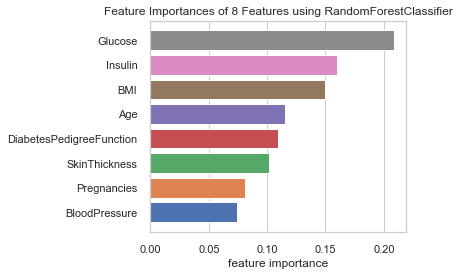

In [44]:
viz = FeatureImportances(forest_clf, relative=False)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

- Although Glucose still is one of the most important features, now the 3rd best is no longer Blood pressure, it is BMI. In fact, Blood Pressure is the least important feature, indicating the difference of impact in comparison to the previous model.

- Blood Pressure now doesn't have a negative coefficent, which means that for the Random Forest higher values are more important to the prediction than lower values, contrary to what happened in SGDC Classifier.

- Unlike previsously, now age has a bigger impact on the prediction. This corroborates what the hypothesis made in the exploratory analysis, that age was important to determine if a person will have diabetes.

In [45]:
# O "score" vai ser a probabilidade de que a amostra seja da classe positiva.
y_probas_forest = cross_val_predict(
    forest_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=3,
    method="predict_proba",
    n_jobs=-1,
)

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_forest = y_probas_forest[:, 1]

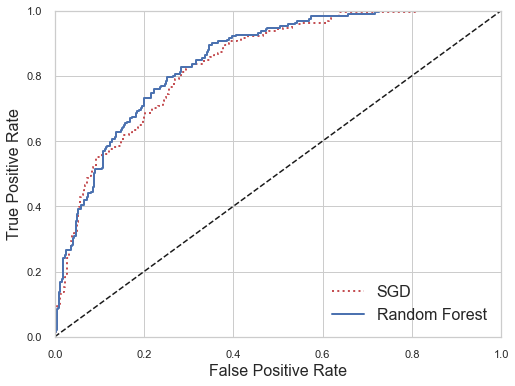

In [46]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(
    diabetes_labels,
    y_scores_forest,
)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "r:", linewidth=2, label="SGD")
plt.plot(fpr_forest, tpr_forest, linewidth=2, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [47]:
from sklearn.metrics import roc_auc_score

print('SGD: {:4f}'.format(roc_auc_score(diabetes_labels, y_scores)))
print('RandomForest: {:4f}'.format(roc_auc_score(diabetes_labels, y_scores_forest)))

SGD: 0.840103
RandomForest: 0.850316


As it can be seen, the Random Forest Classifier has a better performance because the area under the curve is higher.

# Logistic Regression

In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

clf_log = LogisticRegression(random_state=RANDOM_SEED)


t1 = time.process_time()
Log_Score = cross_val_score(
    clf_log,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(Log_Score)

[0.75862069 0.77586207 0.77586207 0.75862069 0.74137931 0.86206897
 0.73684211 0.73684211 0.73684211 0.73684211]


In [67]:
Log_Score.mean()

0.7619782214156079

## Adjusting Hyperparameters

In [49]:
clf_log.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [50]:
param_grid = [
    {
    'penalty' : ['l1', 'l2'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['liblinear']
    },
]

logistic_clf_grid = GridSearchCV(
    clf_log,  # Modelo
    param_grid,  # Grid
    cv=5,  # Partições de C.V.
    scoring='neg_mean_squared_error',
    return_train_score=True,
    n_jobs=-1,
)

In [51]:
logistic_clf_grid.fit(diabetes_train, diabetes_labels)

GridSearchCV(cv=5, estimator=LogisticRegression(random_state=42), n_jobs=-1,
             param_grid=[{'C': array([1.00000000e-04, 2.63665090e-04, 6.95192796e-04, 1.83298071e-03,
       4.83293024e-03, 1.27427499e-02, 3.35981829e-02, 8.85866790e-02,
       2.33572147e-01, 6.15848211e-01, 1.62377674e+00, 4.28133240e+00,
       1.12883789e+01, 2.97635144e+01, 7.84759970e+01, 2.06913808e+02,
       5.45559478e+02, 1.43844989e+03, 3.79269019e+03, 1.00000000e+04]),
                          'penalty': ['l1', 'l2'], 'solver': ['liblinear']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [52]:
logistic_clf_grid.best_params_

{'C': 0.03359818286283781, 'penalty': 'l2', 'solver': 'liblinear'}

In [68]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

clf_log = LogisticRegression(random_state=RANDOM_SEED)


t1 = time.process_time()
Log_Score = cross_val_score(
    logistic_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
t2 = time.process_time()

print(Log_Score)

[0.75862069 0.77586207 0.75862069 0.79310345 0.74137931 0.86206897
 0.73684211 0.73684211 0.73684211 0.77192982]


In [69]:
Log_Score.mean()

0.7672111312764669

## Features Importance

After analysing the importance of features in the logistic regression model, it is noticable that glucose still remains as the most important feature, and pregnancies also becomes the 2nd most important (like in the SGDC classifier). BMI, like the Random Forest model, also becomes one of the top three most important features. The higher the parameter BMI is, the more likely a person is to develop diabtes, according to a study (https://vitagene.com/blog/does-obesity-cause-type-2-diabetes/), therefore it makes sense that this would be one of the most important features.

C:\Users\matfs\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


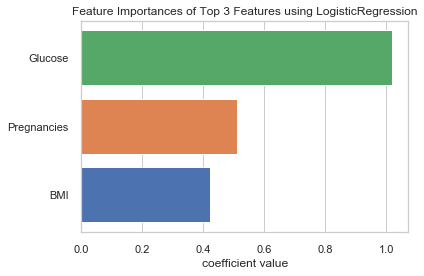

In [53]:
viz = FeatureImportances(clf_log, relative=False, topn=3)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

C:\Users\matfs\Anaconda3\lib\site-packages\yellowbrick\model_selection\importances.py:199: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  YellowbrickWarning,


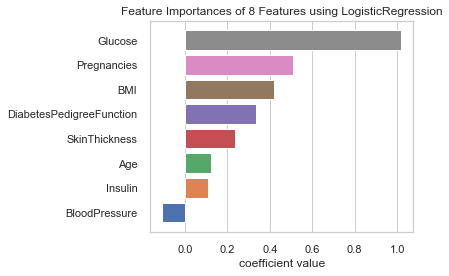

In [54]:
viz = FeatureImportances(clf_log, relative=False)
viz.fit(diabetes_train, diabetes_labels)
viz.show()

In [55]:
# O "score" vai ser a probabilidade de que a amostra seja da classe positiva.
y_probas_logistic = cross_val_predict(
    logistic_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=3,
    method="predict_proba",
    n_jobs=-1,
)

# Gambiarra para desviar do bug #9589 introduzido no Scikit-Learn 0.19.0:
y_scores_logistic = y_probas_forest[:, 1]

In [56]:
Log_Score_Grid = cross_val_score(
    logistic_clf_grid,
    diabetes_train,
    diabetes_labels,
    cv=10,
    scoring="accuracy",
    n_jobs=-1,
)
Log_Score_Grid

array([0.75862069, 0.77586207, 0.75862069, 0.79310345, 0.74137931,
       0.86206897, 0.73684211, 0.73684211, 0.73684211, 0.77192982])

After using the Logistic Regression it is possible to conclude that its performance is better than the SGD classifier, with an accuracy of 76%. 

# SVM

In [57]:
from sklearn.svm import LinearSVC, SVC

clf_svm= SVC(C=1e5, kernel='linear', degree=1,  random_state=RANDOM_SEED)
clf_svm.fit(diabetes_train, diabetes_labels)

SVC(C=100000.0, degree=1, kernel='linear', random_state=42)

In [72]:
%%time
from sklearn.model_selection import GridSearchCV, ShuffleSplit
from pprint import pprint

grid = GridSearchCV(
    clf_svm,
    {
        'C': [10.0**k for k in np.arange(-3, 5, 0.5)], 'kernel': ('linear', 'rbf'),
        'degree': [1, 2, 3, 4, 5, 6]
    },
    scoring='accuracy',
    cv=ShuffleSplit(
        n_splits=100,
        test_size=0.33,
        random_state=RANDOM_SEED,
    ),
    n_jobs=-1,
    verbose=3,
)
# len(clf_svm.get_params().keys())
grid.fit(diabetes_train, diabetes_labels)

print(grid.best_params_)

Fitting 100 folds for each of 192 candidates, totalling 19200 fits


KeyboardInterrupt: 

C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.00100: mean_accuracy = 0.667, stddev_accuracy = 0.026
C = 0.10000: mean_accuracy = 0.771, stddev_accuracy = 0.023
C = 0.10000: mean_accuracy = 0.720, stddev_accuracy = 0.042
C = 0.10000: mean_accuracy = 0.771, stddev_accuracy = 0.023
C = 0.10000: mean_accuracy = 0.720, stddev_accuracy = 0.042
C = 0.10000: mean_accuracy = 0.771, stdd

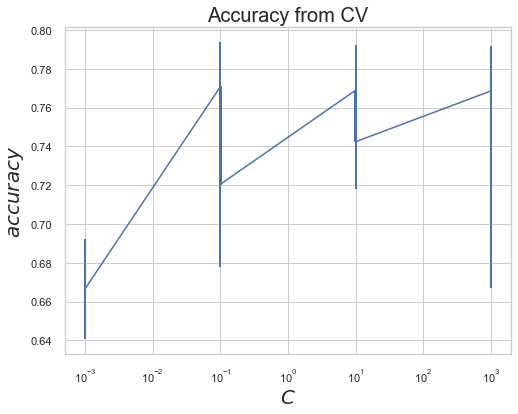

In [59]:
P = np.array([p['C'] for p in grid.cv_results_['params']])
M = grid.cv_results_['mean_test_score']
S = grid.cv_results_['std_test_score']

for p, m, s in zip(P, M, S):
    print(f'C = {p:.5f}: mean_accuracy = {m:.3f}, stddev_accuracy = {s:.3f}')

plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('Accuracy from CV', fontsize=20)
plt.xlabel(r"$C$", fontsize=20)
plt.ylabel(r"$accuracy$", fontsize=20)
plt.show()

In [60]:
#General accuracy of SVM
M.mean()

0.7250130890052354

In [61]:
import random
M_set = set(M)
M_list = list(M_set)
M_list.append(M[random.randint(0,len(M))])
M_list.append(M[random.randint(0,len(M))])
M_list.append(M[random.randint(0,len(M))])

In [62]:
len(M_list)

10

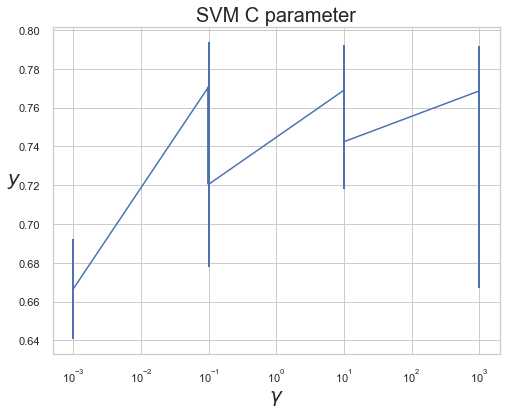

In [71]:
plt.figure(figsize=(8, 6))
plt.errorbar(P, M, S, capsize=4)
plt.semilogx()
plt.title('SVM C parameter', fontsize=20)
plt.xlabel(r"$\gamma$", fontsize=20)
plt.ylabel(r"$y$", fontsize=20, rotation=0)
plt.show()

The idea of SVM algorithm is to trace a curve that can separate when a patient has diabets. However, sometimes the samples are mixed and a curve that completely separates those values is not possible. To calculate the best curve possible, the C parameter used in the algorithm associate penalties to the values that are miscalculated. The higher this parameter is, the less regularization the model will execute, and, hence, overfitting will occur.

This model also has another parameter degree. This determines the degree of the curve that will be used to separate the elements. Whilst creating the model, the grid search was used with this parameter (and also with C), and the outcome was that the model had a better performance when degree was equal to 1. Therefore, the curve obtained is linear.

Finally, it is discoverded that the general accuracy of the Supporting Vector Machine is the diabetes scenario has a 72%  of accuracy.

## Features Importance

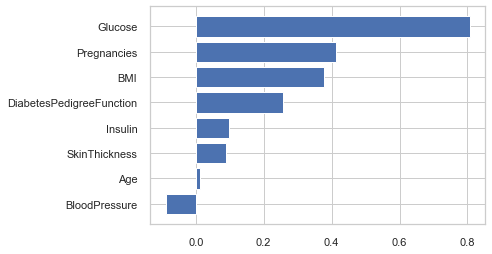

In [63]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

f_importances(clf_svm.coef_[0], diabetes_train.columns.tolist())

After analysing the importance of features in the Supporting Vector Machine model, it is noticable that glucose still remains as the most important feature, and pregnancies also becomes the 2nd most important (similary to the previous models).

# Conclusion

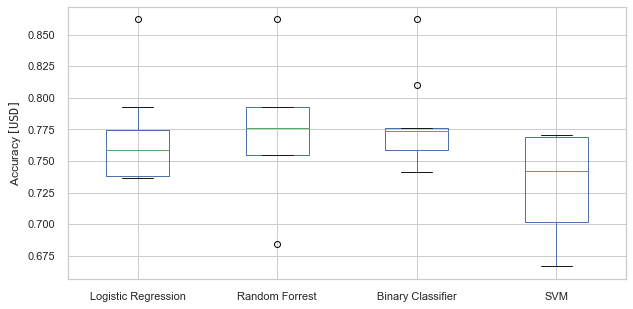

In [64]:
pd.DataFrame({
    'Logistic Regression': Log_Score_Grid,
    'Random Forrest': Random_Forrest_grid_Score,
    'Binary Classifier': Binary_score_grid,
    'SVM': M_list,
}).plot.box(
    xlabel='Regressor',
    ylabel=r'Accuracy $[\mathtt{USD}]$',
    figsize=(10, 5),
);

Analyzing the general results of accuracy of each model, it is possible to understand that all of them had a similar performance. But analyzing the details it is possible to conclude that Random Forrest had the best general accuracy. Moreover, it is intersting to point out that a specific outlier of Logistic Regression, Random Forrest and Binary Classifier had aproximalary the same accuracy. This may have been due to the fact that all of them had the same cut of the cros val and that section of the database impact the best it could to predict if semeone had or not diabetes.

In [65]:
from sklearn.metrics import accuracy_score

final_model = forest_clf_grid.best_estimator_

X_test = strat_test_set.drop('Outcome', axis=1)
y_test = strat_test_set['Outcome'].copy()

X_test_prepared = imputer.transform(X_test)
X_test_prepared = scaler.transform(X_test_prepared)
final_predictions = final_model.predict(X_test_prepared)

final_accuracy = accuracy_score(y_test, final_predictions)

print(f'Accuracy = {final_accuracy}')

Accuracy = 0.7077922077922078


In [66]:
y_test.value_counts(True)

0    0.61039
1    0.38961
Name: Outcome, dtype: float64

**In Conclusion**, the Random Forrest Classifier perfomed a marvelous job, since it had an accuracy of 70,77% in the test set. This shows that not only it doesn't overfit or underfit but also acts much better then a model which just guess that everybody doesn't have diabetes. This is because in the cell above, it is learned that there were 61,03% of people who didn't have diabetes. Therefore a model that only guess, would score an 61,03% of accuracy and the Random Forrest one was 10% better.